In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install biopython

import os
import pandas as pd
import re
from Bio import SeqIO
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay


import math
from collections import defaultdict


# Paths to datasets
positive_fasta_path = 'drive/MyDrive/LB2/second_try/training_positive.fasta'
positive_tsv_path = 'drive/MyDrive/LB2/second_try/training_positive.tsv'
negative_tsv_path = 'drive/MyDrive/LB2/second_try/training_negative.tsv'
combined_csv_path = 'drive/MyDrive/LB2/second_try/filtered_combined_data.csv'
subset_base_path = 'drive/MyDrive/LB2/second_try/cross_validation'

# Function to extract the cleavage site position
def extract_cleavage_site(signal_peptide):
    match = re.search(r"SIGNAL (\d+)\.\.(\d+)", signal_peptide)
    if match:
        return int(match.group(2))
    return None

# Function to extract a fixed range of 15 residues around the cleavage site
def extract_fixed_range(sequence, n_position):
    if pd.isna(n_position):
        return None
    start = max(0, int(n_position) - 12)
    end = min(len(sequence), int(n_position) + 2)
    extracted_sequence = sequence[start:end+1]
    if len(extracted_sequence) == 15:
        return extracted_sequence
    return None

# Load positive sequences from FASTA file
sequences = {record.id.split('|')[1]: str(record.seq) for record in SeqIO.parse(positive_fasta_path, "fasta")}
print(f"Sequences Loaded: {len(sequences)}")

# Load positive data from TSV file
positive_data = pd.read_csv(positive_tsv_path, sep='\t')

# Extract cleavage site and sequence_15aa for positive data
positive_data['cleavage_site'] = positive_data['Signal peptide'].apply(extract_cleavage_site)
positive_data['sequence_15aa'] = positive_data.apply(
    lambda row: extract_fixed_range(sequences.get(row['Entry'], ''), row['cleavage_site']) if pd.notna(row['cleavage_site']) else None, axis=1
)

# Select relevant columns for positive data
positive_data = positive_data[['Entry', 'Entry Name', 'Length', 'Signal peptide', 'cleavage_site', 'sequence_15aa']]
positive_data['label'] = 1

# Load negative data from TSV file
negative_data = pd.read_csv(negative_tsv_path, sep='\t')

# Select relevant columns for negative data
negative_data = negative_data[['Entry', 'Entry Name', 'Length']]
negative_data['Signal peptide'] = ''
negative_data['cleavage_site'] = None
negative_data['sequence_15aa'] = None
negative_data['label'] = 0

# Combine positive and negative data
combined_data = pd.concat([positive_data, negative_data], axis=0).reset_index(drop=True)

# Keep only rows where label is 1 and sequence_15aa is not empty, or label is 0
combined_data = combined_data[(combined_data['label'] == 0) | ((combined_data['label'] == 1) & (combined_data['sequence_15aa'].notna() & (combined_data['sequence_15aa'] != '')))]

# Save combined data to CSV
combined_data.to_csv(combined_csv_path, index=False)
print(f"Filtered combined data saved to {combined_csv_path}")

# Load the filtered combined data
filtered_combined_data = pd.read_csv(combined_csv_path)

# Shuffle the combined data
filtered_combined_data = shuffle(filtered_combined_data).reset_index(drop=True)

# Split into 5 subsets for cross-validation
subsets = np.array_split(filtered_combined_data, 5)
print("Split data into 5 subsets for cross-validation.")

# Function to save datasets
def save_datasets(base_path, subset_name, train_data, val_data, test_data):
    subset_dir = os.path.join(base_path, subset_name)
    os.makedirs(subset_dir, exist_ok=True)

    train_path = os.path.join(subset_dir, 'train.tsv')
    val_path = os.path.join(subset_dir, 'val.tsv')
    test_path = os.path.join(subset_dir, 'test.tsv')

    train_data.to_csv(train_path, sep='\t', index=False)
    val_data.to_csv(val_path, sep='\t', index=False)
    test_data.to_csv(test_path, sep='\t', index=False)

    print(f'Subset {subset_name}:')
    print(f'  Training set - Positives: {train_data[train_data["label"] == 1].shape[0]}, Negatives: {train_data[train_data["label"] == 0].shape[0]}')
    print(f'  Validation set - Positives: {val_data[val_data["label"] == 1].shape[0]}, Negatives: {val_data[val_data["label"] == 0].shape[0]}')
    print(f'  Testing set - Positives: {test_data[test_data["label"] == 1].shape[0]}, Negatives: {test_data[test_data["label"] == 0].shape[0]}')

# Define the subsets for train, validation, and test
train_indices = [0, 1, 2]
val_index = 3
test_index = 4

# Combine the train subsets
train_data = pd.concat([subsets[i] for i in train_indices], ignore_index=True)
val_data = subsets[val_index]
test_data = subsets[test_index]

# Save the datasets
subset_name = 'train123_val4_test5'
save_datasets(subset_base_path, subset_name, train_data, val_data, test_data)



# Background frequencies from SwissProt
background_frequencies = {
    "A": 0.0825, "R": 0.0553, "N": 0.0406, "D": 0.0546, "C": 0.0138,
    "Q": 0.0393, "E": 0.0672, "G": 0.0707, "H": 0.0227, "I": 0.0591,
    "L": 0.0965, "K": 0.0580, "M": 0.0241, "F": 0.0386, "P": 0.0474,
    "S": 0.0665, "T": 0.0536, "W": 0.0110, "Y": 0.0292, "V": 0.0685
}

# Function to calculate frequencies
def calculate_frequencies(sequences, window_size=15):
    frequencies = defaultdict(lambda: [0] * window_size)
    total_counts = [0] * window_size

    for seq in sequences:
        for i, aa in enumerate(seq):
            if i < window_size:
                frequencies[aa][i] += 1
                total_counts[i] += 1

    for aa in frequencies:
        for i in range(window_size):
            frequencies[aa][i] = (frequencies[aa][i] + 1) / (total_counts[i] + 20)  # Add pseudocount and divide by N + 20

    return frequencies

# Function to create PSWM
def create_von_heijne_matrix(sequences, background_frequencies, window_size=15):
    frequencies = calculate_frequencies(sequences, window_size)
    matrix = pd.DataFrame(frequencies).T

    # Normalize and convert to log-odds scores
    for aa in matrix.index:
        if aa not in background_frequencies:
            print(f"Warning: Amino acid '{aa}' not found in background frequencies. Skipping.")
            continue
        for i in range(window_size):
            matrix.at[aa, i] /= background_frequencies[aa]
            matrix.at[aa, i] = math.log(matrix.at[aa, i])

    return matrix

# Extract sequences from the positive data
positive_sequences = train_data[train_data['label'] == 1]['sequence_15aa'].dropna().tolist()
print(f"Number of positive sequences: {len(positive_sequences)}")

# Create the Von Heijne matrix
von_heijne_matrix = create_von_heijne_matrix(positive_sequences, background_frequencies)

# Display the matrix
print("Matrix before normalization and log transformation:")
print(von_heijne_matrix)

# Save the matrix to a file for future use
von_heijne_matrix.to_csv('drive/MyDrive/LB2/second_try/von_heijne_matrix.csv', index=True)



# Load the benchmarking data
benchmarking_data = pd.read_csv(benchmarking_data_path)
print(f"Benchmarking data loaded: {benchmarking_data.shape[0]} rows")

# Apply the PSWM model to the benchmarking dataset
benchmarking_data = apply_pswm_model(benchmarking_data, pswm)

# Ensure there are no NaN values in the score column
benchmarking_data = benchmarking_data.dropna(subset=['score'])

# Evaluate the model on the benchmarking set using the optimal threshold
accuracy, precision, recall, f1, report = evaluate_model(benchmarking_data, optimal_threshold)

# Print benchmarking results
print(f'Benchmarking set - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
print(f'Benchmarking set classification report:\n{report}')

# Save the benchmarking results
benchmarking_data.to_csv('drive/MyDrive/LB2/second_try/benchmarking_results_von_heijne.csv', index=False)
print('Benchmarking results saved to drive/MyDrive/LB2/second_try/benchmarking_results_von_heijne.csv')


# Function to plot the ROC curve
def plot_roc_curve(y_true, y_scores, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title(title)

# Create the 2x2 grid for plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# ROC Curve for Test Set
plt.subplot(2, 2, 1)
plot_roc_curve(test_data['label'], test_data['score'], title='ROC Curve (Test Set)')

# Confusion Matrix for Test Set
plt.subplot(2, 2, 2)
test_data['prediction'] = test_data['score'] >= optimal_threshold
plot_confusion_matrix(test_data['label'], test_data['prediction'], title='Confusion Matrix (Test Set)')

# ROC Curve for Benchmarking Set
plt.subplot(2, 2, 3)
plot_roc_curve(benchmarking_data['label'], benchmarking_data['score'], title='ROC Curve (Benchmarking Set)')

# Confusion Matrix for Benchmarking Set
plt.subplot(2, 2, 4)
benchmarking_data['prediction'] = benchmarking_data['score'] >= optimal_threshold
plot_confusion_matrix(benchmarking_data['label'], benchmarking_data['prediction'], title='Confusion Matrix (Benchmarking Set)')

plt.tight_layout()
plt.show()


MessageError: Error: credential propagation was unsuccessful

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 17.5 MB/s eta 0:00:00


## Signal Peptide Prediction Workflow Using von Heijne's Method



### **step 1: Data Preparation**

Combined positive and negative sequences.

Extracted the cleavage site positions and 15-residue sequences around these positions.

Filtered and shuffled the combined data, then split it into training, validation, and test sets.


In [ ]:
import os
import pandas as pd
import re
from Bio import SeqIO
from sklearn.utils import shuffle

# Paths to datasets
positive_fasta_path = 'drive/MyDrive/LB2/second_try/training_positive.fasta'
positive_tsv_path = 'drive/MyDrive/LB2/second_try/training_positive.tsv'
negative_tsv_path = 'drive/MyDrive/LB2/second_try/training_negative.tsv'
combined_csv_path = 'drive/MyDrive/LB2/second_try/filtered_combined_data.csv'
subset_base_path = 'drive/MyDrive/LB2/second_try/cross_validation'

# Function to extract the cleavage site position
def extract_cleavage_site(signal_peptide):
    match = re.search(r"SIGNAL (\d+)\.\.(\d+)", signal_peptide)
    if match:
        return int(match.group(2))
    return None

# Function to extract a fixed range of 15 residues around the cleavage site
def extract_fixed_range(sequence, n_position):
    if pd.isna(n_position):
        return None
    start = max(0, int(n_position) - 12)
    end = min(len(sequence), int(n_position) + 2)
    extracted_sequence = sequence[start:end+1]
    if len(extracted_sequence) == 15:
        return extracted_sequence
    return None

# Load positive sequences from FASTA file
sequences = {record.id.split('|')[1]: str(record.seq) for record in SeqIO.parse(positive_fasta_path, "fasta")}
print(f"Sequences Loaded: {len(sequences)}")

# Load positive data from TSV file
positive_data = pd.read_csv(positive_tsv_path, sep='\t')

# Extract cleavage site and sequence_15aa for positive data
positive_data['cleavage_site'] = positive_data['Signal peptide'].apply(extract_cleavage_site)
positive_data['sequence_15aa'] = positive_data.apply(
    lambda row: extract_fixed_range(sequences.get(row['Entry'], ''), row['cleavage_site']) if pd.notna(row['cleavage_site']) else None, axis=1
)

# Select relevant columns for positive data
positive_data = positive_data[['Entry', 'Entry Name', 'Length', 'Signal peptide', 'cleavage_site', 'sequence_15aa']]
positive_data['label'] = 1

# Load negative data from TSV file
negative_data = pd.read_csv(negative_tsv_path, sep='\t')

# Select relevant columns for negative data
negative_data = negative_data[['Entry', 'Entry Name', 'Length']]
negative_data['Signal peptide'] = ''
negative_data['cleavage_site'] = None
negative_data['sequence_15aa'] = None
negative_data['label'] = 0

# Combine positive and negative data
combined_data = pd.concat([positive_data, negative_data], axis=0).reset_index(drop=True)

# Keep only rows where label is 1 and sequence_15aa is not empty, or label is 0
combined_data = combined_data[(combined_data['label'] == 0) | ((combined_data['label'] == 1) & (combined_data['sequence_15aa'].notna() & (combined_data['sequence_15aa'] != '')))]

# Save combined data to CSV
combined_data.to_csv(combined_csv_path, index=False)
print(f"Filtered combined data saved to {combined_csv_path}")

# Load the filtered combined data
filtered_combined_data = pd.read_csv(combined_csv_path)

# Shuffle the combined data
filtered_combined_data = shuffle(filtered_combined_data).reset_index(drop=True)

# Split into 5 subsets for cross-validation
subsets = np.array_split(filtered_combined_data, 5)
print("Split data into 5 subsets for cross-validation.")

# Function to save datasets
def save_datasets(base_path, subset_name, train_data, val_data, test_data):
    subset_dir = os.path.join(base_path, subset_name)
    os.makedirs(subset_dir, exist_ok=True)

    train_path = os.path.join(subset_dir, 'train.tsv')
    val_path = os.path.join(subset_dir, 'val.tsv')
    test_path = os.path.join(subset_dir, 'test.tsv')

    train_data.to_csv(train_path, sep='\t', index=False)
    val_data.to_csv(val_path, sep='\t', index=False)
    test_data.to_csv(test_path, sep='\t', index=False)

    print(f'Subset {subset_name}:')
    print(f'  Training set - Positives: {train_data[train_data["label"] == 1].shape[0]}, Negatives: {train_data[train_data["label"] == 0].shape[0]}')
    print(f'  Validation set - Positives: {val_data[val_data["label"] == 1].shape[0]}, Negatives: {val_data[val_data["label"] == 0].shape[0]}')
    print(f'  Testing set - Positives: {test_data[test_data["label"] == 1].shape[0]}, Negatives: {test_data[test_data["label"] == 0].shape[0]}')

# Define the subsets for train, validation, and test
train_indices = [0, 1, 2]
val_index = 3
test_index = 4

# Combine the train subsets
train_data = pd.concat([subsets[i] for i in train_indices], ignore_index=True)
val_data = subsets[val_index]
test_data = subsets[test_index]

# Save the datasets
subset_name = 'train123_val4_test5'
save_datasets(subset_base_path, subset_name, train_data, val_data, test_data)



import numpy as np
from sklearn.metrics import precision_recall_curve, auc, classification_report

# Load the PSWM
von_heijne_matrix_path = 'drive/MyDrive/LB2/second_try/von_heijne_matrix.csv'
von_heijne_matrix = pd.read_csv(von_heijne_matrix_path, index_col=0)

# Convert the matrix to a dictionary for easier access with integer keys
pswm = {aa: {int(pos): value for pos, value in positions.items()} for aa, positions in von_heijne_matrix.to_dict(orient='index').items()}

# Function to score a sequence using the PSWM
def score_sequence_pswm(sequence, pswm):
    score = 0
    if pd.notna(sequence):
        for i, aa in enumerate(sequence):
            if aa in pswm:
                if i in pswm[aa]:  # Ensure the position exists in the dictionary
                    score += pswm[aa][i]
                else:
                    print(f"Warning: Position {i} for amino acid '{aa}' out of range.")
            else:
                if aa != 'X':  # Skip warning for 'X'
                    print(f"Warning: Amino acid '{aa}' not found in PSWM.")
    return score

# Function to apply the PSWM model to a dataset and get scores
def apply_pswm_model(data, pswm):
    data['score'] = data['sequence_15aa'].apply(lambda seq: score_sequence_pswm(seq, pswm))
    return data

# Apply the PSWM model to training, validation, and test sets
train_data = apply_pswm_model(train_data, pswm)
val_data = apply_pswm_model(val_data, pswm)
test_data = apply_pswm_model(test_data, pswm)

# Ensure there are no NaN values in the score column
val_data = val_data.dropna(subset=['score'])
test_data = test_data.dropna(subset=['score'])

# Function to find the optimal threshold
def find_optimal_threshold(y_true, y_scores):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    fscore = (2 * precision * recall) / (precision + recall)
    index = np.argmax(fscore)
    optimal_threshold = thresholds[index]
    return optimal_threshold

# Find the optimal threshold using the validation set
optimal_threshold = find_optimal_threshold(val_data['label'], val_data['score'])
print(f'Optimal threshold found: {optimal_threshold}')

# Function to evaluate the model on a given dataset
def evaluate_model(data, threshold):
    data = data.copy()
    data['prediction'] = data['score'] >= threshold
    tp = sum((data['label'] == 1) & (data['prediction'] == 1))
    tn = sum((data['label'] == 0) & (data['prediction'] == 0))
    fp = sum((data['label'] == 0) & (data['prediction'] == 1))
    fn = sum((data['label'] == 1) & (data['prediction'] == 0))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    report = classification_report(data['label'], data['prediction'], target_names=['Negative', 'Positive'], zero_division=0)

    return accuracy, precision, recall, f1, report

# Evaluate on the test set using the optimal threshold
accuracy, precision, recall, f1, report = evaluate_model(test_data, optimal_threshold)
print(f'Test set - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
print(f'Test set classification report:\n{report}')


Sequences Loaded: 621


<ipython-input-15-692e94d9cf22>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_data['label'] = 1


Filtered combined data saved to drive/MyDrive/LB2/second_try/filtered_combined_data.csv
Split data into 5 subsets for cross-validation.
Subset train123_val4_test5:
  Training set - Positives: 264, Negatives: 3677
  Validation set - Positives: 112, Negatives: 1201
  Testing set - Positives: 115, Negatives: 1198



### **Step 2: Creating the Position-Specific Weight Matrix (PSWM)**

Calculated the amino acid frequencies from the positive sequences.

Converted the frequencies into log-odds scores using background frequencies derived from SwissProt.

In [ ]:
import math
from collections import defaultdict

# Background frequencies from SwissProt
background_frequencies = {
    "A": 0.0825, "R": 0.0553, "N": 0.0406, "D": 0.0546, "C": 0.0138,
    "Q": 0.0393, "E": 0.0672, "G": 0.0707, "H": 0.0227, "I": 0.0591,
    "L": 0.0965, "K": 0.0580, "M": 0.0241, "F": 0.0386, "P": 0.0474,
    "S": 0.0665, "T": 0.0536, "W": 0.0110, "Y": 0.0292, "V": 0.0685
}

# Function to calculate frequencies
def calculate_frequencies(sequences, window_size=15):
    frequencies = defaultdict(lambda: [0] * window_size)
    total_counts = [0] * window_size

    for seq in sequences:
        for i, aa in enumerate(seq):
            if i < window_size:
                frequencies[aa][i] += 1
                total_counts[i] += 1

    for aa in frequencies:
        for i in range(window_size):
            frequencies[aa][i] = (frequencies[aa][i] + 1) / (total_counts[i] + 20)  # Add pseudocount and divide by N + 20

    return frequencies

# Function to create PSWM
def create_von_heijne_matrix(sequences, background_frequencies, window_size=15):
    frequencies = calculate_frequencies(sequences, window_size)
    matrix = pd.DataFrame(frequencies).T

    # Normalize and convert to log-odds scores
    for aa in matrix.index:
        if aa not in background_frequencies:
            print(f"Warning: Amino acid '{aa}' not found in background frequencies. Skipping.")
            continue
        for i in range(window_size):
            matrix.at[aa, i] /= background_frequencies[aa]
            matrix.at[aa, i] = math.log(matrix.at[aa, i])

    return matrix

# Extract sequences from the positive data
positive_sequences = train_data[train_data['label'] == 1]['sequence_15aa'].dropna().tolist()
print(f"Number of positive sequences: {len(positive_sequences)}")

# Create the Von Heijne matrix
von_heijne_matrix = create_von_heijne_matrix(positive_sequences, background_frequencies)

# Display the matrix
print("Matrix before normalization and log transformation:")
print(von_heijne_matrix)

# Save the matrix to a file for future use
von_heijne_matrix.to_csv('drive/MyDrive/LB2/second_try/von_heijne_matrix.csv', index=True)


Number of positive sequences: 264
Matrix before normalization and log transformation:
         0         1         2         3         4         5         6   \
A  0.483569 -0.062975  0.213279  0.559555  0.429502  0.342490  0.509544   
C  1.119019  0.713554  0.831337  0.936698  1.273170  1.342163  0.831337   
L  1.380586  1.371369  1.416626  1.389718  1.120055  1.166575  0.601261   
V  0.290044  0.615466  0.290044 -0.134839 -0.077681 -0.260003  0.793147   
P -0.402617 -0.808082 -0.653931 -0.808082 -1.213547 -0.297256  0.535653   
Q -1.313831 -1.026149 -1.719296 -1.313831 -0.215219 -0.333002 -2.412443   
T -1.336474 -0.776858 -0.237861 -0.525543  0.368274 -0.237861 -0.014718   
F  0.824405  0.244586  0.824405  0.090435  0.313579  0.549968  0.090435   
Y -1.016775 -0.729093 -1.422240 -1.422240 -0.505950  0.081837 -0.505950   
R -2.753992 -2.060845 -1.367698 -1.655380 -2.060845 -1.144554 -2.060845   
G -1.613370 -0.514758 -0.920223 -0.601769 -0.434715 -0.601769 -0.802440   
D -2.048106 -2

### **Step 3: Model Training and Evaluation:**


*  Applied the PSWM to the training, validation, and test sets.

*  Found the optimal threshold for classification using the validation set.

*   Evaluated the model on the test set and reported performance metrics.

*   Applied the model to a separate benchmarking set to ensure robust performance. (*Blind test*)









In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc, classification_report

# Load the PSWM
von_heijne_matrix_path = 'drive/MyDrive/LB2/second_try/von_heijne_matrix.csv'
von_heijne_matrix = pd.read_csv(von_heijne_matrix_path, index_col=0)

# Convert the matrix to a dictionary for easier access with integer keys
pswm = {aa: {int(pos): value for pos, value in positions.items()} for aa, positions in von_heijne_matrix.to_dict(orient='index').items()}

# Function to score a sequence using the PSWM
def score_sequence_pswm(sequence, pswm):
    score = 0
    if pd.notna(sequence):
        for i, aa in enumerate(sequence):
            if aa in pswm:
                if i in pswm[aa]:  # Ensure the position exists in the dictionary
                    score += pswm[aa][i]
                else:
                    print(f"Warning: Position {i} for amino acid '{aa}' out of range.")
            else:
                if aa != 'X':  # Skip warning for 'X'
                    print(f"Warning: Amino acid '{aa}' not found in PSWM.")
    return score

# Function to apply the PSWM model to a dataset and get scores
def apply_pswm_model(data, pswm):
    data['score'] = data['sequence_15aa'].apply(lambda seq: score_sequence_pswm(seq, pswm))
    return data

# Apply the PSWM model to training, validation, and test sets
train_data = apply_pswm_model(train_data, pswm)
val_data = apply_pswm_model(val_data, pswm)
test_data = apply_pswm_model(test_data, pswm)

# Ensure there are no NaN values in the score column
val_data = val_data.dropna(subset=['score'])
test_data = test_data.dropna(subset=['score'])

# Function to find the optimal threshold
def find_optimal_threshold(y_true, y_scores):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    fscore = (2 * precision * recall) / (precision + recall)
    index = np.argmax(fscore)
    optimal_threshold = thresholds[index]
    return optimal_threshold

# Find the optimal threshold using the validation set
optimal_threshold = find_optimal_threshold(val_data['label'], val_data['score'])
print(f'Optimal threshold found: {optimal_threshold}')

# Function to evaluate the model on a given dataset
def evaluate_model(data, threshold):
    data = data.copy()
    data['prediction'] = data['score'] >= threshold
    tp = sum((data['label'] == 1) & (data['prediction'] == 1))
    tn = sum((data['label'] == 0) & (data['prediction'] == 0))
    fp = sum((data['label'] == 0) & (data['prediction'] == 1))
    fn = sum((data['label'] == 1) & (data['prediction'] == 0))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    report = classification_report(data['label'], data['prediction'], target_names=['Negative', 'Positive'], zero_division=0)

    return accuracy, precision, recall, f1, report

# Evaluate on the test set using the optimal threshold
accuracy, precision, recall, f1, report = evaluate_model(test_data, optimal_threshold)
print(f'Test set - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
print(f'Test set classification report:\n{report}')


Optimal threshold found: 0.43851452024499893
Test set - Accuracy: 0.9954, Precision: 1.0000, Recall: 0.9478, F1 Score: 0.9732
Test set classification report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      1198
    Positive       1.00      0.95      0.97       115

    accuracy                           1.00      1313
   macro avg       1.00      0.97      0.99      1313
weighted avg       1.00      1.00      1.00      1313



### **Step 4: Evaluate with Blind Test**

Evaluate the model using the benchmarking dataset.

In [ ]:
# Load the benchmarking data
benchmarking_data = pd.read_csv(benchmarking_data_path)
print(f"Benchmarking data loaded: {benchmarking_data.shape[0]} rows")

# Apply the PSWM model to the benchmarking dataset
benchmarking_data = apply_pswm_model(benchmarking_data, pswm)

# Ensure there are no NaN values in the score column
benchmarking_data = benchmarking_data.dropna(subset=['score'])

# Evaluate the model on the benchmarking set using the optimal threshold
accuracy, precision, recall, f1, report = evaluate_model(benchmarking_data, optimal_threshold)

# Print benchmarking results
print(f'Benchmarking set - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
print(f'Benchmarking set classification report:\n{report}')

# Save the benchmarking results
benchmarking_data.to_csv('drive/MyDrive/LB2/second_try/benchmarking_results_von_heijne.csv', index=False)
print('Benchmarking results saved to drive/MyDrive/LB2/second_try/benchmarking_results_von_heijne.csv')


Benchmarking data loaded: 1639 rows
Benchmarking set - Accuracy: 0.9963, Precision: 1.0000, Recall: 0.9500, F1 Score: 0.9744
Benchmarking set classification report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      1519
    Positive       1.00      0.95      0.97       120

    accuracy                           1.00      1639
   macro avg       1.00      0.97      0.99      1639
weighted avg       1.00      1.00      1.00      1639

Benchmarking results saved to drive/MyDrive/LB2/second_try/benchmarking_results_von_heijne.csv


The model demonstrates excellent performance on both the test and benchmarking datasets.
It shows high precision, ensuring no false positives, and strong recall, capturing most of the positive cases.
The results indicate the model is robust and generalizes well to unseen data, making it reliable for predicting signal peptides.

### **Step 5: Visualizing Model Performance**

**The ROC curves and AUC values** indicate that the model has a high capability of distinguishing between positive and negative classes, with slightly better performance on the benchmarking set.

**The confusion matrices** show that the model has very high accuracy, with zero false positives and a minimal number of false negatives in both the test and benchmarking datasets.

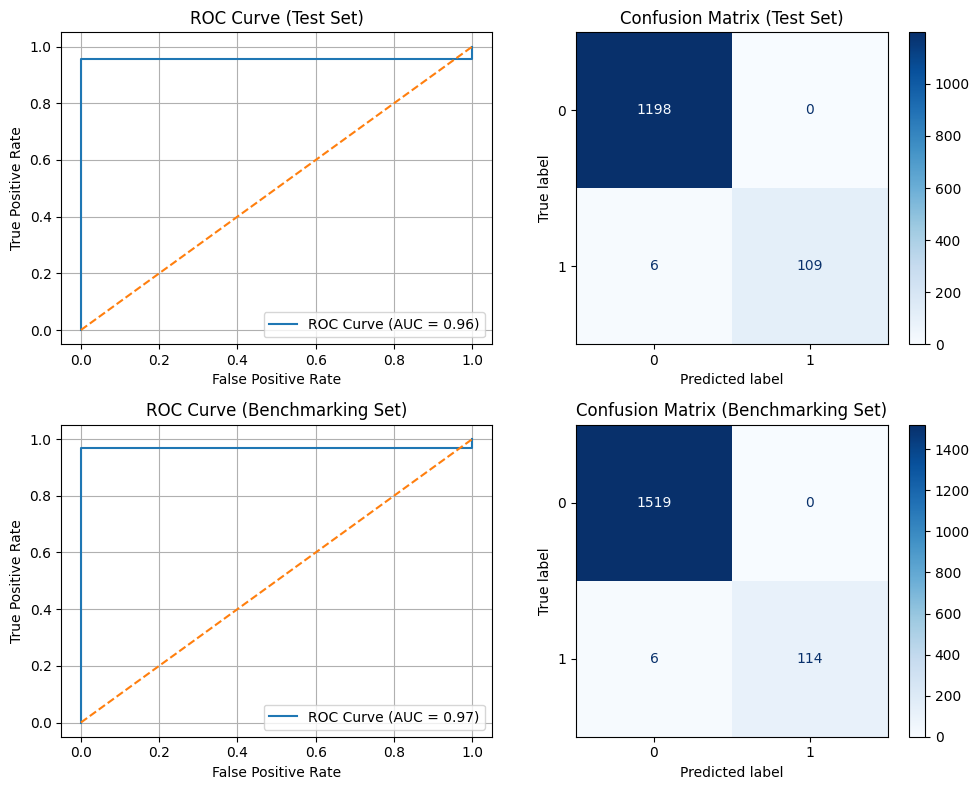

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Function to plot the ROC curve
def plot_roc_curve(y_true, y_scores, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title(title)

# Create the 2x2 grid for plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# ROC Curve for Test Set
plt.subplot(2, 2, 1)
plot_roc_curve(test_data['label'], test_data['score'], title='ROC Curve (Test Set)')

# Confusion Matrix for Test Set
plt.subplot(2, 2, 2)
test_data['prediction'] = test_data['score'] >= optimal_threshold
plot_confusion_matrix(test_data['label'], test_data['prediction'], title='Confusion Matrix (Test Set)')

# ROC Curve for Benchmarking Set
plt.subplot(2, 2, 3)
plot_roc_curve(benchmarking_data['label'], benchmarking_data['score'], title='ROC Curve (Benchmarking Set)')

# Confusion Matrix for Benchmarking Set
plt.subplot(2, 2, 4)
benchmarking_data['prediction'] = benchmarking_data['score'] >= optimal_threshold
plot_confusion_matrix(benchmarking_data['label'], benchmarking_data['prediction'], title='Confusion Matrix (Benchmarking Set)')

plt.tight_layout()
plt.show()
